# Analysing CSV Data

<div class="alert alert-block alert-warning">
<b> 

- *In this part we need Analyse CSV data from Southern Australia Police regarding the crime. Perform Preliminary data analysis and finally inferring some useful information through visualisation.*

</b>
</div> 

## 1. Intializing Spark

In [1]:
# importing packages
import os
import numpy as np
from datetime import datetime      # for datatype conersion

import matplotlib.pyplot as plt    # for visualisation
import matplotlib.style as style

from pyspark.sql.functions import udf , year, month, dayofmonth , concat_ws
# udf function helps us to define our own functions
# year, month, dayofmonth are for extraction of year, month and day from datetime datatyoe

from pyspark.sql.types import DateType    # for returning datatype as Datetype
#-------------------------------------------------------------------------------------------------------------

# create entry points to spark
from pyspark import SparkContext, SparkConf # Spark
from pyspark.sql import SparkSession # Spark SQL

<div class="alert alert-block alert-info">
<b> 
    
    
1.  os.env----- sets the environment given in the string


2.  PYSPARK_SUBMIT_ARGS------ takes the arguments as JARS that you want to execute, pyspark_submit takes files and executes it.


3.  --packages------- indicates to downlod the given package



4.  org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell-------  is in the form of  <br> 

   groupid : artifactid : versionid, in our case we get mongo-spark-connector which acts as connecting point between Mongodb and Spark 

</b>
</div> 

In [ ]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'

In [ ]:
# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]")
    
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("Analysing CSV data")\

        # spark.jars.packages includes mongo-spark-connector on the driver and executor classpaths
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\

        # spark.mongodb.input.uri specifies Mondodb server address, the database to connect, fit_db and 
        # the collection southern_aus_coll.
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit_db.southern_aus_coll")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit_db.southern_aus_coll")\

        .getOrCreate()

## 2. Creating Dataframe

In [2]:
# creating spark sql dataframe from CSV file
crime = spark.read.csv('Crime_Statistics_SA_2010_present.csv', header=True, inferSchema=True)

## 3. Writing to Database

In [3]:
# writing the dataframe to mongodb collection assignment_coll
crime.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

## 4. Reading from Database

In [4]:
# reading from the database
crime_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

## 5. Statistics for numeric and string columns

In [9]:
# droping the null rows for consistent processing
crime_df = crime_df.na.drop()

In [5]:
# statistics for column Offence Count
crime_df.select('Offence Count').describe().show()

+-------+------------------+
|summary|     Offence Count|
+-------+------------------+
|  count|            727407|
|   mean|1.1715174585892079|
| stddev|0.5787050930378129|
|    min|                 1|
|    max|                28|
+-------+------------------+



In [10]:
# statistics for column Reported Date
crime_df.select('Reported Date').describe().show()

+-------+-------------+
|summary|Reported Date|
+-------+-------------+
|  count|       726921|
|   mean|         null|
| stddev|         null|
|    min|    1/01/2011|
|    max|    9/12/2018|
+-------+-------------+



## 6. Preliminary Data analysis

### 6.1. The number of level 2 offences

In [49]:
crime_df.groupby('Offence Level 2 Description')\                    # grouping on level 2 offence
         .sum('Offence Count')\                                     # adding the offences
         .withColumnRenamed("sum(Offence Count)" ,"Offence Count")\ # renaming the column
         .show()

+---------------------------+-------------+
|Offence Level 2 Description|Offence Count|
+---------------------------+-------------+
|       ROBBERY AND RELAT...|         6242|
|       PROPERTY DAMAGE A...|       200683|
|       SEXUAL ASSAULT AN...|        13974|
|       HOMICIDE AND RELA...|          478|
|       ACTS INTENDED TO ...|       130161|
|       SERIOUS CRIMINAL ...|       115124|
|       OTHER OFFENCES AG...|        24625|
|       FRAUD DECEPTION A...|        21525|
|       THEFT AND RELATED...|       338848|
+---------------------------+-------------+



### 6.2. Number of offences against person

In [56]:
crime_df.filter(crime_df['Offence Level 1 Description'] == "OFFENCES AGAINST THE PERSON")\ # filtering with offences against person
        .groupby()\                                                                        # groupiing
        .sum()\                                                                            # adding up offences
        .withColumnRenamed("sum(Offence Count)" ,"Offences against person")\               # renaming
        .show()

+-----------------------+
|Offences against person|
+-----------------------+
|                 175480|
+-----------------------+



### 6.3. Serious criminal trespass with more than 1 offence count

In [51]:
# filtering the data for serious criminal trespass and more than 1 offence count
crime_df.filter((crime_df['Offence Level 2 Description'] == "SERIOUS CRIMINAL TRESPASS") & (crime_df['Offence Count'] > 1)).count()

8574

### 6.4. Percentage of crimes are offences against property

In [87]:
property = crime_df.filter(crime_df['Offence Level 1 Description'] == "OFFENCES AGAINST PROPERTY")\ # getting offences against property
                    .groupby().sum('Offence Count').collect()

total = crime_df.groupby().sum().collect()    # getting total number of offences

(property[0]['sum(Offence Count)'])/(total[0]['sum(Offence Count)'])*100  # getting %

79.3955334288331

## 7. Changing data type of a column

In [11]:
date_udf = udf( lambda x : datetime.strptime(x, '%d/%m/%Y').date() , DateType())  # defining user defined function

X = crime_df.withColumn( 'Reported Date',date_udf(crime_df['Reported date']))

## 8. Exploratory data analysis

### 8.1. Number of crimes per year

In [12]:
Crime_year = X.withColumn('Year' , year(X['Reported Date']))\     # adding year column
                .groupby('Year')\                                 # grouping on the basis of year
                .sum('Offence Count')\                            # adding offences
                .sort('sum(Offence Count)',ascending=False)\      # sorting in desc order
                .withColumnRenamed("sum(Offence Count)" ,"Offence Count")\     # renaming the column
                .collect()

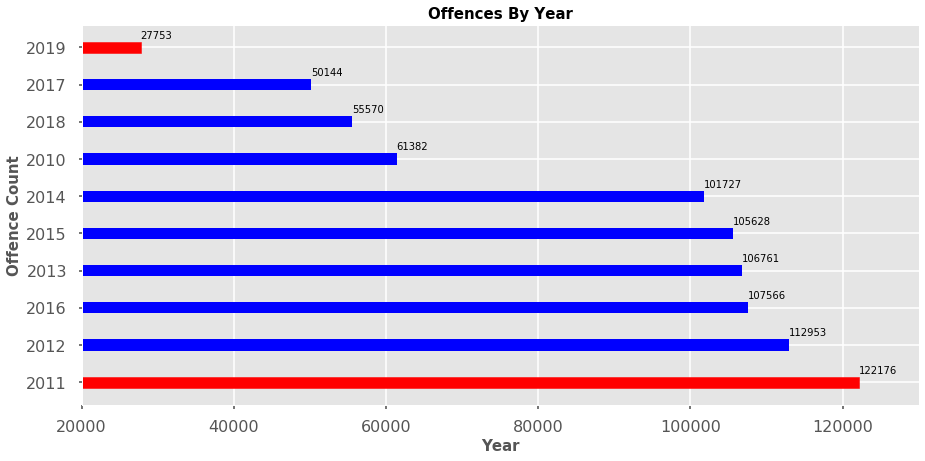

In [13]:
style.use('seaborn-poster')                                         # setting the canvas
style.use('ggplot')

y_axis = [row['Offence Count'] for row in Crime_year]               # getting list of offence count

objects = [row['Year'] for row in Crime_year]                       # getting list of the year

y_pos = np.arange(len(objects))

plt.figure(figsize = (15,7))                                        # setting fig size

barplot = plt.barh(y_pos, y_axis, 0.3, align='center', color='b')   # plotting horizontal bar plot
barplot[0].set_color("red")                                         # highlighting the first and last 
barplot[9].set_color("red")

for i, v in enumerate(y_axis):                                      # adding text on bar
    plt.text(v + 3, i + .25, str(v), color='black')
    
plt.yticks(y_pos, objects)                                          
plt.xlabel('Year', fontsize = 15, weight = 'bold')
plt.ylabel('Offence Count', fontsize = 15, weight = 'bold')
plt.title('Offences By Year', fontsize = 15, weight = 'bold')       # title of the graph
plt.xlim(20000,130000)
plt.show()

<center> <h1> Inference </h1> </center>

<div class="alert alert-block alert-success">
<b>1. Crime almost doubled in 2011 as compared to 2010, which continued to increase and decrease within the range of 100k to 120k.
    <br>
    <br>    
2. However, for the year 2017 crime decreased by a factor of 2. 
    <br>
    <br>
3. There is nothing suprising about such less no of crime in 2019, the data is only of March 2019 i.e. 3 months. For 3 months the crime is high as comapred to 2018. </b>
</div> 

### 8.2. Number of crimes per month

In [14]:
Crime_month = X.withColumn('Month' , month(X['Reported Date']))\
                .groupby('Month')\
                .sum('Offence Count')\
                .sort('sum(Offence Count)',ascending=False)\
                .withColumnRenamed("sum(Offence Count)" ,"Offence Count")\
                .collect()

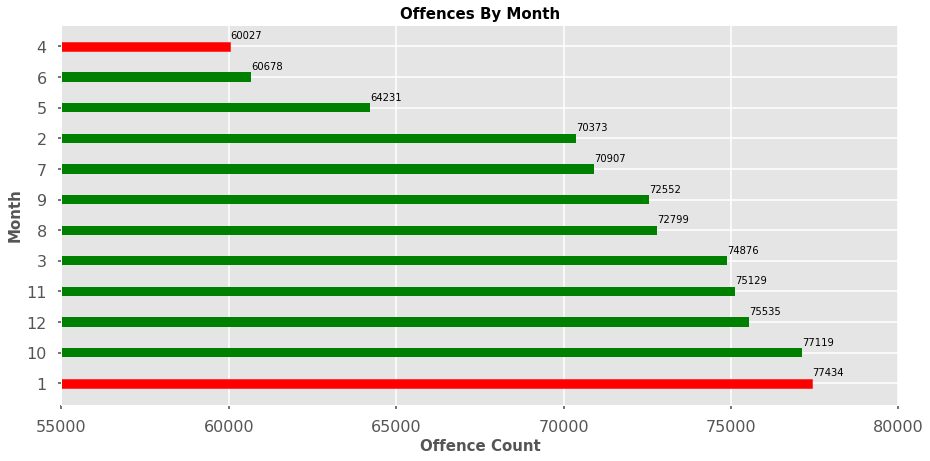

In [15]:
y_axis = [row['Offence Count'] for row in Crime_month]

objects = [row['Month'] for row in Crime_month]

y_pos = np.arange(len(objects))
plt.figure(figsize = (15,7))

barplot = plt.barh(y_pos, y_axis, 0.3, align='center', color='g')
barplot[0].set_color("red")
barplot[11].set_color("red")

for i, v in enumerate(y_axis):
    plt.text(v + 3, i + .25, str(v), color='black')
    
plt.yticks(y_pos, objects)
plt.xlabel('Offence Count' , fontsize = 15, weight = 'bold')
plt.ylabel('Month' , fontsize = 15, weight = 'bold')
plt.xlim(55000,80000)
plt.title('Offences By Month', fontsize = 15, weight = 'bold')
plt.show()

<center> <h1> Inference </h1> </center>

<div class="alert alert-block alert-success">
<b>1. Observing the graph, we can say infer that January, December, March, November are prone to crime rates.
    <br>
    <br>    
2. Summer falls under these months for Australia, during which people leave their houses for vacation, hence high probability of crime against property
    <br>
    <br>
3. More gatherings of people, Southern Australia has many festivals such as WOMAdelaide, Adelaide Fringe in which millions of people gather, high probab of causing stress, public robberies </b>
</div> 

### 8.3. Number of crimes by Suburb

In [44]:
Crime_suburbs = crime_df.withColumn('Suburb',concat_ws(" - ",crime_df['Suburb - Incident'],crime_df['Postcode - Incident']))\
                        .groupby('Suburb')\
                        .sum('Offence Count')\
                        .sort('sum(Offence Count)',ascending=False)\
                        .withColumnRenamed("sum(Offence Count)" ,"Offence Count")\
                        .take(20)

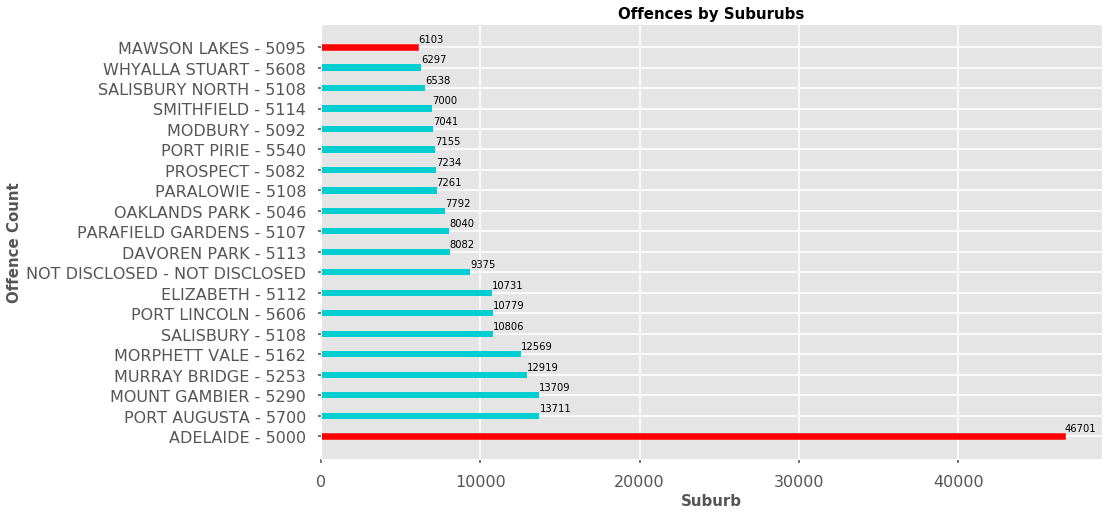

In [45]:
plt.figure(figsize = (14,8))

y_axis = [row['Offence Count'] for row in Crime_suburbs]

objects = [row['Suburb'] for row in Crime_suburbs]

y_pos = np.arange(len(objects))

barplot = plt.barh(y_pos, y_axis, 0.3 , align='center', color='darkturquoise')
plt.yticks(y_pos, objects)
barplot[0].set_color("red")
barplot[19].set_color("red")

for i, v in enumerate(y_axis):
    plt.text(v + 3, i + .25, str(v), color='black')
    
plt.xlabel('Suburb',  fontsize = 15, weight = 'bold')
plt.ylabel('Offence Count' ,   fontsize = 15, weight = 'bold')
plt.title('Offences by Suburubs',   fontsize = 15, weight = 'bold')
plt.show()

<center> <h1> Inference </h1> </center>

<div class="alert alert-block alert-success">
<b>1. Top of the graph is Adelaide, which has a population about 1 million will but obvious have the highest crime as compared to other suburbs which have population in thousands.
    <br>
    <br>    
2. Adelaide being the only biggest city in southern australia and one of the study centric city for international students, hence higher probability of crime.
 </b>
</div> 

### 8.4. Serious criminal trespasses by day and month

- BY DAY

In [16]:
SCT_day = X.withColumn('Day' , dayofmonth(X['Reported Date']))\
                .filter(crime_df['Offence Level 2 Description'] == "SERIOUS CRIMINAL TRESPASS")\
                .groupby('Day')\
                .sum('Offence Count')\
                .sort('sum(Offence Count)',ascending=False)\
                .withColumnRenamed("sum(Offence Count)" ,"Offence Count")\
                .collect()

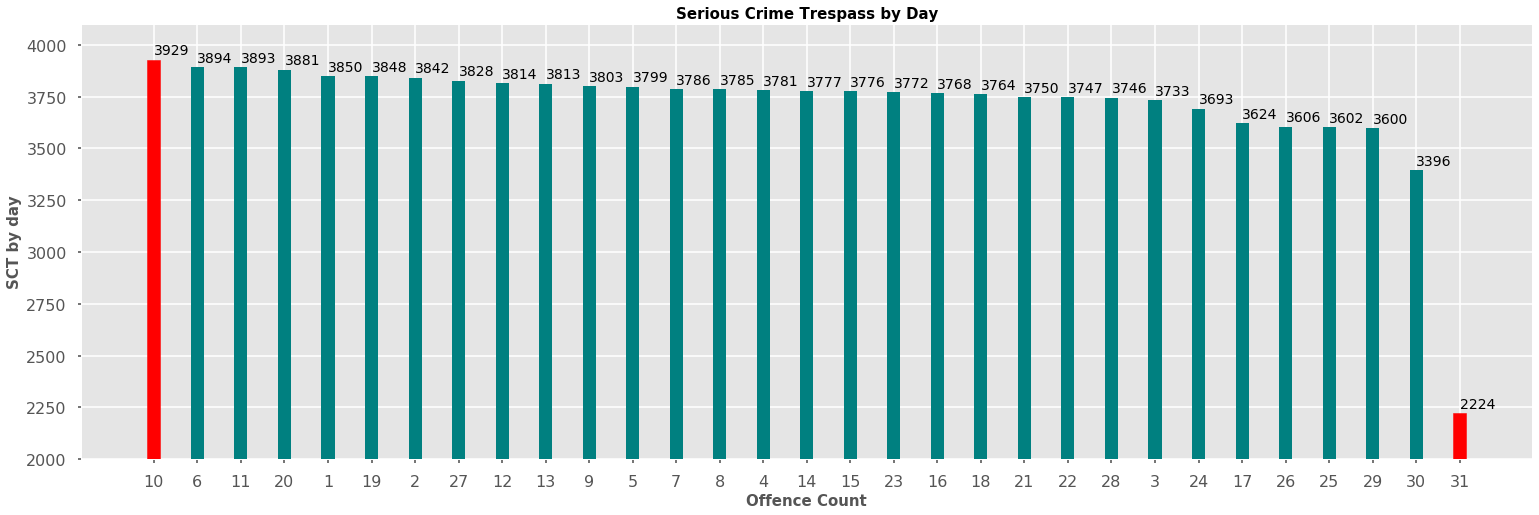

In [41]:
plt.figure(figsize = (26,8))

y_axis = [row['Offence Count'] for row in SCT_day]

objects = [row['Day'] for row in SCT_day]

y_pos = np.arange(len(objects))


barplot = plt.bar(y_pos, y_axis, 0.3, align='center', color='teal')
barplot[0].set_color("red")
barplot[30].set_color("red")

for i, v in enumerate(y_axis):
    plt.text(i, v + 25, str(v), color='black'  ,fontsize = 14)
    
plt.xticks(y_pos, objects)
plt.ylim((2000,4100))
plt.xlabel('Offence Count' , fontsize = 15, weight = 'bold')
plt.ylabel('SCT by day' , fontsize = 15, weight = 'bold')
plt.title('Serious Crime Trespass by Day', fontsize = 15, weight = 'bold')
plt.show()

<center> <h1> Inference </h1> </center>

<div class="alert alert-block alert-success">
<b>1. Trespassing does not vary so much on the days, it is constant for most of the days.
    <br>
    <br>    
2. 31st violates the pattern, it has lowest no of Serious Criminal Trespass
 </b>
</div> 

- BY MONTH

In [42]:
SCT_month = X.withColumn('Month' , month(X['Reported Date']))\
                .filter(crime_df['Offence Level 2 Description'] == "SERIOUS CRIMINAL TRESPASS")\
                .groupby('Month')\
                .sum('Offence Count')\
                .sort('sum(Offence Count)',ascending=False)\
                .withColumnRenamed("sum(Offence Count)" ,"Offence Count")\
                .collect()

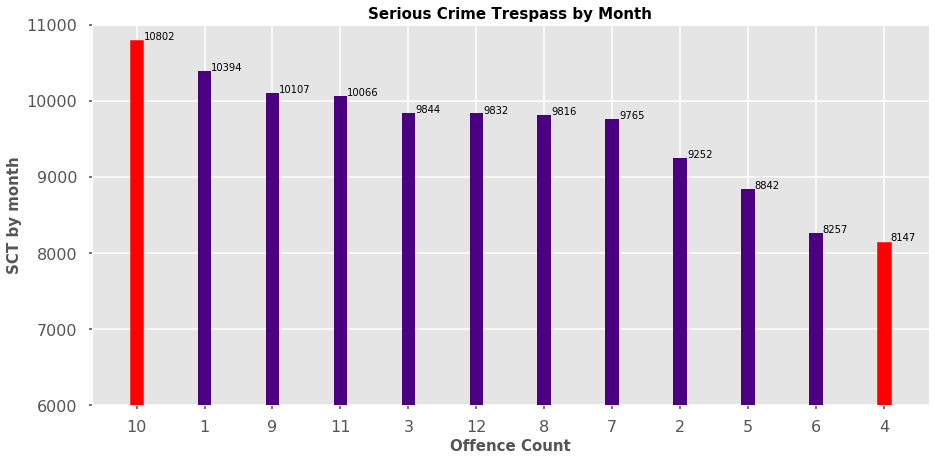

In [43]:
y_axis = [row['Offence Count'] for row in SCT_month]

objects = [row['Month'] for row in SCT_month]

y_pos = np.arange(len(objects))

plt.figure(figsize = (15,7))
barplot = plt.bar(y_pos, y_axis, 0.2, align='center', color='indigo')
barplot[0].set_color("red")
barplot[11].set_color("red")

for i, v in enumerate(y_axis):
    plt.text(i+.1 , i+v, str(v), color='black')
    
plt.xticks(y_pos, objects)
plt.ylim((6000,11000))
plt.xlabel('Offence Count', fontsize = 15, weight = 'bold')
plt.ylabel('SCT by month',  fontsize = 15, weight = 'bold')
plt.title('Serious Crime Trespass by Month',   fontsize = 15, weight = 'bold')
plt.show()

<center> <h1> Inference </h1> </center>

<div class="alert alert-block alert-success">
<b>1. October, Jan, Nov, March have high trespassing because of two reasons. 
    <br>
    <br>    
- First is Summer, more number of gatherings, more number of robberies.
    <br>
    <br>
- Second is festivals, as mentioned earlier Southern Australia has a number of festivals in this season.
 </b>
</div> 